# Libraries

In [13]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import imutils

# Functions

In [39]:
def get_circles(img):
    img = (img * 255).astype("uint8")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # threshold the difference image, followed by finding contours to
    # obtain the regions of the two input images that differ

    blurred_mask = cv2.blur(gray, (80, 80)) 

    
#    print(np.average(blurred_mask))
    thresh, maxValue = 100, 256
    th, dst = cv2.threshold(blurred_mask, thresh, maxValue, cv2.THRESH_BINARY)
    
    detected_circles = cv2.HoughCircles(dst,  
                   cv2.HOUGH_GRADIENT, 1.2, 100, param1 = 50, param2 = 37, minRadius = 0, maxRadius = 0) 
    return detected_circles, dst, blurred_mask #, np.average(img), np.average(blurred_mask)

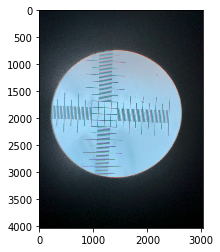

In [40]:
img = cv2.imread('Images/IMG_1716.JPG', cv2.IMREAD_COLOR)
plt.imshow(img)

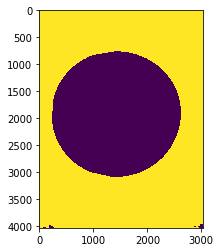

In [41]:
detected_circles, dst, blurred_mask = get_circles(img)
plt.imshow(dst)

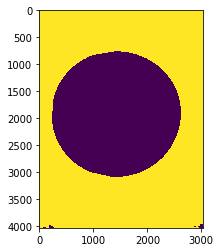

In [42]:
plt.imshow(dst)

In [43]:
detected_circles

In [44]:
circles = img.copy()

# Draw circles that are detected. 
if detected_circles is not None: 
  
    # Convert the circle parameters a, b and r to integers. 
    detected_circles = np.uint16(np.around(detected_circles)) 
  
    for pt in detected_circles[0, :]: 
        a, b, r = pt[0], pt[1], pt[2] 
        # Draw the circumference of the circle. 
        cv2.circle(circles, (a, b), r, (0, 0, 255), 2) 
        print('a: ' + str(a) + ' b: ' + str(b))
  
        # Draw a small circle (of radius 1) to show the center. 
        cv2.circle(circles, (a, b), 1, (255, 0, 0), 3) 

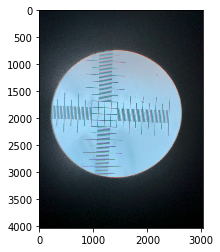

In [45]:
plt.imshow(circles)